In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

year='2017'

In [4]:
indir = "outfiles/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)

started = 0
for filename in infiles:
    
    if "data" in filename:
        continue
    if "bsm" in filename:
        continue

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)
        scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in out['sumw'].items()}
        out['templates'].scale(scale_lumi, 'dataset')
        tmp = out['templates'].group('dataset', hist.Cat('process', 'Process'), pmap).sum('genflavor1','genflavor2').integrate('region','signal')

        if started == 0:
            templates = tmp
            started += 1
        else:
            templates.add(tmp)
    
        del out

Loading outfiles/2017_dask_higgs.coffea
Loading outfiles/2017_dask_qcd.coffea
Loading outfiles/2017_dask_top.coffea
Loading outfiles/2017_dask_wandvv.coffea
Loading outfiles/2017_dask_z.coffea


In [5]:
templates

<Hist (process,msd1,msd2,ddb1,ddc2) instance at 0x7fa3e79ed970>

In [6]:
sr = templates.sum('msd2')

In [7]:
def nc_sig(s,b):
    return np.sqrt(2*(s+b)*np.log(1+1.0*s/b)-2*s)

def quad_sig(h,ddcvb,ddbvl):
    # charm category
    h1 = h.integrate('ddb1',int_range=slice(ddbvl,1)).integrate('ddc2',int_range=slice(ddcvb,1))
    s1 = h1.integrate('process',['ZH','WH']).values()[()]
    b1 = h1.integrate('process',['QCD','ttbar','Wjets','Zjets','singlet','VV','ggF','VBF','ttH']).values()[()]
    z1 = nc_sig(s1,b1)
    
    # light category
    h2 = h.integrate('ddb1',int_range=slice(ddbvl,1)).integrate('ddc2',int_range=slice(0,ddcvb))
    s2 = h2.integrate('process',['ZH','WH']).values()[()]
    b2 = h2.integrate('process',['QCD','ttbar','Wjets','Zjets','singlet','VV','ggF','VBF','ttH']).values()[()]
    z2 = nc_sig(s2,b2)
    
    return np.sqrt(z1*z1+z2*z2)

In [19]:
sigs = []

for b in range(0,25):    
    sig1 = []
    for c in [0,0.01,0.02,0.05,0.1,0.2,0.5]:
        z = quad_sig(sr.integrate('msd1',int_range=slice(110,138)),c,b*0.04)
        sig1 += [z]
    print(b*0.04,max(sig1))
    sigs += [sig1]

0.0 0.5072456286845844
0.04 0.6349233991030576
0.08 0.7336280998559974
0.12 0.83134748626593
0.16 0.9166433640044273
0.2 1.0136298777959274
0.24 1.0713060819060667
0.28 1.1305883642096353
0.32 1.1935612674695573
0.36 1.2766716376578464
0.4 1.3419740315447595
0.44 1.4481376266175516
0.48 1.4705397046686437
0.52 1.7839025164799756
0.56 1.582560542374628
0.6 1.6323523281399803
0.64 1.7149688519058686
0.68 1.5903553831147939
0.72 1.6715451369840526
0.76 1.582728654858567
0.8 1.803022842945712
0.84 2.466553850742159
0.88 2.2171905406381223
0.92 inf
0.96 inf


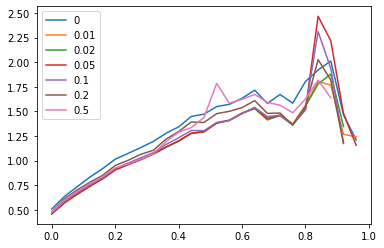

In [28]:
plt.plot([b*0.04 for b in range(0,25)],sigs,label=["0","0.01","0.02","0.05","0.1","0.2","0.5"])
plt.legend()

In [16]:
sigs[int(0.84*25)]

[1.9203928310907286,
 1.8028871581572552,
 1.7782737298975009,
 1.7782737298975009,
 1.7782737298975009,
 2.466553850742159,
 2.310012324148701,
 2.0258812681549667,
 1.8176263572932743]

In [18]:
sr.identifiers('ddc2')

[<Interval ([0, 0.01)) instance at 0x7fa3e79f2850>,
 <Interval ([0.01, 0.02)) instance at 0x7fa3e79f2970>,
 <Interval ([0.02, 0.05)) instance at 0x7fa3e79f2400>,
 <Interval ([0.05, 0.1)) instance at 0x7fa3e6893850>,
 <Interval ([0.1, 0.2)) instance at 0x7fa3e6893e50>,
 <Interval ([0.2, 0.5)) instance at 0x7fa3e6893970>,
 <Interval ([0.5, 1)) instance at 0x7fa3e6893940>]